In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pycountry
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from geopy.geocoders import Nominatim
import pickle

sns.set_style('darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from graphviz import Digraph

In [2]:
df_train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv') 
df_test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')

df_train['Date'] = pd.to_datetime(df_train['Date'], format = '%Y-%m-%d')
df_test['Date'] = pd.to_datetime(df_test['Date'], format = '%Y-%m-%d')

stamp = dt.datetime(2020, 4, 14)

df_train = df_train[df_train['Date']<=stamp]
df_test = df_test[df_test['Date']<=stamp]

df_train['Days'] = df_train['Date']-df_train['Date'].min()

df_train.Province_State.fillna('ZZZ', inplace=True)
df_test.Province_State.fillna('ZZZ', inplace=True)

df_train['Days'] = df_train['Days'].astype('timedelta64[D]')
#print (df_test)

In [3]:
dict_geo = {}
#print (df_train)
df_mid = df_train.groupby(['Country_Region','Province_State'],as_index=False)
print (len(df_mid))
df_metadata = pd.read_csv('/kaggle/input/covid19-forecasting-metadata/region_metadata.csv') 
df_metadata.Province_State.fillna('ZZZ', inplace=True)
dict_key = df_metadata.groupby(['Country_Region','Province_State'],as_index=False)

for name,group in df_mid:
    #print (name)
    i = df_metadata[(df_metadata['Country_Region']== name[0])&(df_metadata['Province_State']== name[1])].index.tolist()[0]
    #print (i)
    lat = df_metadata.loc[i,'lat']
    long = df_metadata.loc[i,'lon']
    pop = df_metadata.loc[i,'population']
    area = df_metadata.loc[i,'area']
    dict_geo.update({name:[lat,long,pop,area]})

313


In [4]:
def add_daily_measures(df):
    df.loc[0,'Daily Cases'] = df.loc[0,'ConfirmedCases']
    df.loc[0,'Daily Deaths'] = df.loc[0,'Fatalities']
    for i in range(1,len(df)):
        df.loc[i,'Daily Cases'] = df.loc[i,'ConfirmedCases'] - df.loc[i-1,'ConfirmedCases']
        df.loc[i,'Daily Deaths'] = df.loc[i,'Fatalities'] - df.loc[i-1,'Fatalities']
        if df.loc[i,'Daily Deaths']<0:
            df.loc[i,'Daily Deaths'] = df.loc[i-1,'Daily Deaths']
        if df.loc[i,'Daily Cases']<0:
            df.loc[i,'Daily Cases'] = df.loc[i-1,'Daily Cases']
        df.loc[i,'lastconfirm'] = df.loc[i-1,'ConfirmedCases']
        df.loc[i,'lastdeath'] = df.loc[i-1,'Fatalities']
    #Make the first row as 0 because we don't know the previous value
    df.loc[0,'Daily Cases'] = 0
    df.loc[0,'Daily Deaths'] = 0
    df.loc[0,'lastconfirm'] = 0
    df.loc[0,'lastdeath'] = 0
    return df

In [5]:
def train_dev_split(df, days):
    #Last days data as dev set
    date = df['Date'].max() - dt.timedelta(days=days)
    return df,df[df['Date'] <= date], df[df['Date'] > date]

def add_more_daily_measures(df):

    for i in range(4,len(df)):
        
        df.loc[i,'Daily Cases 1'] = df.loc[i-1,'Daily Cases']
        df.loc[i,'Daily Deaths 1'] = df.loc[i-1,'Daily Deaths']
        
        df.loc[i,'Daily Cases 2'] = df.loc[i-2,'Daily Cases']
        df.loc[i,'Daily Deaths 2'] = df.loc[i-2,'Daily Deaths']
        
        df.loc[i,'Daily Cases 3'] = df.loc[i-3,'Daily Cases']
        df.loc[i,'Daily Deaths 3'] = df.loc[i-3,'Daily Deaths']
        
    #Make the first row as 0 because we don't know the previous value
    df.loc[0,'Daily Cases 1'] = 0
    df.loc[0,'Daily Deaths 1'] = 0
    
    df.loc[0,'Daily Cases 2'] = 0
    df.loc[0,'Daily Deaths 2'] = 0
    
    df.loc[0,'Daily Cases 3'] = 0
    df.loc[0,'Daily Deaths 3'] = 0
    
    df.loc[1,'Daily Cases 1'] =  df.loc[0,'Daily Cases']
    df.loc[1,'Daily Deaths 1'] = df.loc[0,'Daily Deaths']
        
    df.loc[1,'Daily Cases 2'] =  0
    df.loc[1,'Daily Deaths 2'] = 0
    
    df.loc[1,'Daily Cases 3'] =  0
    df.loc[1,'Daily Deaths 3'] = 0

    
    df.loc[2,'Daily Cases 1'] =  df.loc[1,'Daily Cases']
    df.loc[2,'Daily Deaths 1'] = df.loc[1,'Daily Deaths']
        
    df.loc[2,'Daily Cases 2'] =  df.loc[0,'Daily Cases']
    df.loc[2,'Daily Deaths 2'] = df.loc[0,'Daily Deaths']
    
    df.loc[2,'Daily Cases 3'] =  0
    df.loc[2,'Daily Deaths 3'] = 0

    return df

In [6]:
df_list = []
grouped = df_train.groupby(['Country_Region','Province_State'],as_index=False)


for name,group in grouped:
    #print (name)
    df_tmp = df_train[(df_train["Country_Region"]==name[0]) & (df_train["Province_State"] == name[1])].reset_index(drop = True)
    df_tmp = add_daily_measures(df_tmp)
    #df_tmp['Daily Cases'] = np.log(df_tmp['Daily Cases']+1)
    #df_tmp['Daily Deaths'] = np.log(df_tmp['Daily Deaths']+1)
    df_tmp = add_more_daily_measures(df_tmp)
    df_tmp['Lat'] = dict_geo[name][0]
    df_tmp['Long'] = dict_geo[name][1]
    df_tmp['population'] = dict_geo[name][2]
    df_tmp['area'] = dict_geo[name][3]
    df_tmp['popdensity'] = dict_geo[name][2]/dict_geo[name][3]
    df_list.append(df_tmp)
    #print (df_tmp)
    
df_concat = pd.concat(df_list,ignore_index=True)
#print (df_concat)

#df_train = create_features(df_train)
df_train = df_concat
#df_train['Lat'] = df_train['Lat']+90
#df_train['Long'] = df_train['Lat']+90
df_train,df_past,df_dev = train_dev_split(df_train,13)
#print (df_dev)
columns =['Daily Cases 3','Daily Cases 2','Daily Cases 1','Daily Deaths 3','Daily Deaths 2','Daily Deaths 1','Lat','Long','population','area','popdensity','lastconfirm','lastdeath','Days','Province_State', 'Country_Region','ConfirmedCases','Fatalities','Daily Cases','Daily Deaths']
df_train = df_train[columns]
#print (df_train)
df_dev = df_dev[columns]

In [7]:
columns_test =  ['Daily Cases 3','Daily Cases 2','Daily Cases 1','Daily Deaths 3','Daily Deaths 2','Daily Deaths 1','Lat','Long','population','area','popdensity','lastconfirm','lastdeath','Days']

def generate_test_feature(df):
    #print (df)
    alpha = []
    beta = []
    df_target = pd.DataFrame(columns = columns_test)
    df_adjust = df.tail(7)
    
    df_alpha = df_adjust['Daily Cases'].values
    #print (df_alpha)

    for i in range(6):
        alpha.append(df_alpha[i+1]-df_alpha[i])
    #print (alpha)
    
    df_beta = df_adjust['Daily Deaths'].values
    #print (df_beta)
    
    for i in range(6):
        beta.append(df_beta[i+1]-df_beta[i])
    #print (beta)
    
    df_tmp = df.tail(1)
    #print (df_tmp)

    df_target['Daily Cases 3'] = df_tmp['Daily Cases 2']
    df_target['Daily Cases 2'] = df_tmp['Daily Cases 1']
    df_target['Daily Cases 1'] = df_tmp['Daily Cases']
    
    df_target['Daily Deaths 3'] = df_tmp['Daily Deaths 2']
    df_target['Daily Deaths 2'] = df_tmp['Daily Deaths 1']
    df_target['Daily Deaths 1'] = df_tmp['Daily Deaths']
    
    df_target['Lat'] = df_tmp['Lat']  
    df_target['Long'] = df_tmp['Long']
    df_target['population'] = df_tmp['population']
    df_target['area'] = df_tmp['area'] 
    df_target['popdensity'] = df_tmp['popdensity']  
    df_target['lastconfirm'] = df_tmp['ConfirmedCases']  
    df_target['lastdeath'] = df_tmp['Fatalities']
    df_target['Days'] = df_tmp['Days']+1
    
    return df_target,sum(alpha),sum(beta)

In [8]:
d = {'ForecastId':[], 'ConfirmedCases':[], 'Fatalities':[]}
submission_confirm = []
submission_death = []

china_train = df_train[(df_train['Country_Region']=='China')&(df_train['Days']>50)]
china_death = china_train.drop(['Country_Region','Province_State','ConfirmedCases','Fatalities','Daily Cases'], axis=1)
china_death = china_death.values
china_confirm = china_train.drop(['Country_Region','Province_State','ConfirmedCases','Fatalities','Daily Deaths 3','Daily Deaths 2','Daily Deaths 1','Daily Deaths'], axis=1)
china_confirm = china_confirm.values

df_train_noch = df_train[(df_train['Days']>50)&(df_train['Country_Region']!='China')]

train_death = df_train_noch.drop(['Country_Region','Province_State','ConfirmedCases','Fatalities','Daily Cases'], axis=1)
print (train_death.columns)
train_death = train_death.values
train_death = np.append(china_death,train_death,axis = 0)
#print (train_death)


train_confirm = df_train_noch.drop(['Country_Region','Province_State','ConfirmedCases','Fatalities','Daily Deaths 3','Daily Deaths 2','Daily Deaths 1','Daily Deaths'], axis=1)
print (train_confirm.columns)
train_confirm = train_confirm.values
train_confirm = np.append(china_confirm,train_confirm,axis = 0)
#print (train_confirm)

X_train_confirm, y_train_confirm = train_confirm[:,:-1], train_confirm[:,-1:]
X_train_death, y_train_death = train_death[:,:-1], train_death[:,-1:]

#model1 for predicting Confirmed Cases
model1 = XGBRegressor(n_estimators = 1000,learning_rate = 0.1,tree_method='gpu_hist')
model1.fit(X_train_confirm, y_train_confirm[:,0])
#model2 for predicting Fatalities
model2 = XGBRegressor(n_estimators = 1000,learning_rate = 0.1,tree_method='gpu_hist')
model2.fit(X_train_death, y_train_death[:,0])

#Loop through all the unique countries
for country in df_train.Country_Region.unique():
    if  country=='China':
        alpha = 0.1
    else:
        alpha = 1
    df_train1 = df_train[df_train["Country_Region"]==country]
    for state in df_train1.Province_State.unique():
        df_train2 = df_train1[df_train1["Province_State"]==state]
        #print (df_train2.tail(7))
        df_train3 = df_train2.drop(['Country_Region','Province_State'], axis=1)
        
        df_overlay = df_dev[(df_dev["Country_Region"]==country)&(df_dev["Province_State"]==state)]
        #print  (df_overlay['ConfirmedCases'].values)
        
        submission_confirm =submission_confirm + df_overlay['ConfirmedCases'].values.tolist()
        submission_death =submission_death + df_overlay['Fatalities'].values.tolist()         
        
        for i in range (30):
        
            #get test feature
            df_target,confirm_fact,deaths_fact =  generate_test_feature(df_train3)
            df_target_death = df_target[columns_test]
            df_target_confirm = df_target[columns_test].drop(['Daily Deaths 3','Daily Deaths 2','Daily Deaths 1'], axis=1)
            
            target_confirm = df_target_confirm.values
            target_death = df_target_death.values
            
            if confirm_fact<0:
                y_pred1 = abs(model1.predict(target_confirm))*0.85*alpha
            else:
                y_pred1 = abs(model1.predict(target_confirm))*alpha
            if deaths_fact<0:
                y_pred2 = abs(model2.predict(target_death))*0.8*alpha
            else:
                y_pred2 = abs(model2.predict(target_death))*alpha
            #y_pred1 = np.exp(y_pred1)
            #y_pred2 = np.exp(y_pred2)
            
            #print (state,country,'new confirm:',target[0][11]+int(y_pred1),'new deaths:',target[0][12]+int(y_pred2))
            #print (state,country,'last 3 new confirm:',target_death[0][:3],'new confirm:',int(y_pred1),'last 3 new death:',target_death[0][3:6],'new death:',int(y_pred2),'days:',target_death[0][-1])
            submission_confirm.append(target_death[0][11]+int(y_pred1))
            submission_death.append(target_death[0][12]+int(y_pred2))

            target = target_death.flatten()

            target = np.append(target,target[11]+int(y_pred1))
            target = np.append(target,target[12]+int(y_pred2))
            target = np.append(target,int(y_pred1))
            target = np.append(target,int(y_pred2))   

            target = np.reshape(target, (1, 18))
            last_index = df_train3.tail(1).index.values[0]

            df_train3.loc[last_index+1] = target[0]

                                      
d['ConfirmedCases'] = submission_confirm
d['Fatalities'] = submission_death
a = np.arange(1,len(submission_death)+1,1)
d['ForecastId'] = a 


Index(['Daily Cases 3', 'Daily Cases 2', 'Daily Cases 1', 'Daily Deaths 3',
       'Daily Deaths 2', 'Daily Deaths 1', 'Lat', 'Long', 'population', 'area',
       'popdensity', 'lastconfirm', 'lastdeath', 'Days', 'Daily Deaths'],
      dtype='object')
Index(['Daily Cases 3', 'Daily Cases 2', 'Daily Cases 1', 'Lat', 'Long',
       'population', 'area', 'popdensity', 'lastconfirm', 'lastdeath', 'Days',
       'Daily Cases'],
      dtype='object')


In [9]:
print(model1.feature_importances_)
print(model2.feature_importances_)

df_submit = pd.DataFrame(d)
print (df_submit.head())
df_submit.to_csv(r'submission.csv', index=False)

[0.03722166 0.659352   0.1991854  0.00654905 0.03377996 0.00791052
 0.0049871  0.01593523 0.0051132  0.01745464 0.01251123]
[0.00159183 0.00324796 0.00153008 0.10462982 0.10370696 0.76264745
 0.00205878 0.00088782 0.00569295 0.00112198 0.00104322 0.00202086
 0.00560355 0.00421665]
   ForecastId  ConfirmedCases  Fatalities
0           1           273.0         6.0
1           2           281.0         6.0
2           3           299.0         7.0
3           4           349.0         7.0
4           5           367.0        11.0


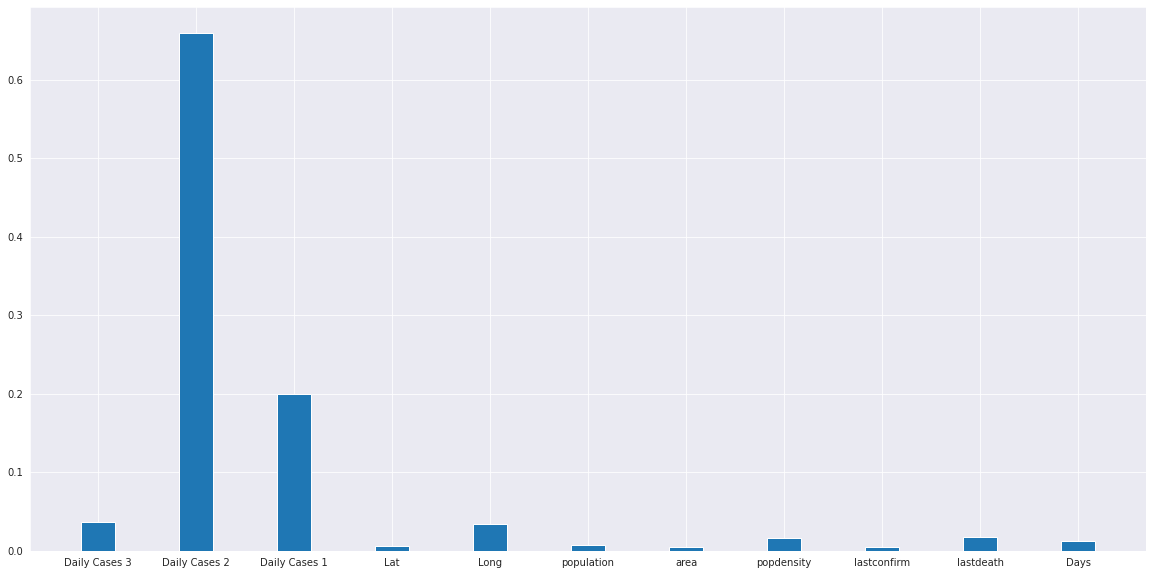

In [10]:
feature_name = ['Daily Cases 3', 'Daily Cases 2', 'Daily Cases 1', 'Lat', 'Long','population', 'area', 'popdensity', 'lastconfirm', 'lastdeath', 'Days']
plt.figure(figsize=(20,10))
plt.bar(feature_name, model1.feature_importances_,width = 0.35)
plt.savefig("model1_feature.png")
plt.show()


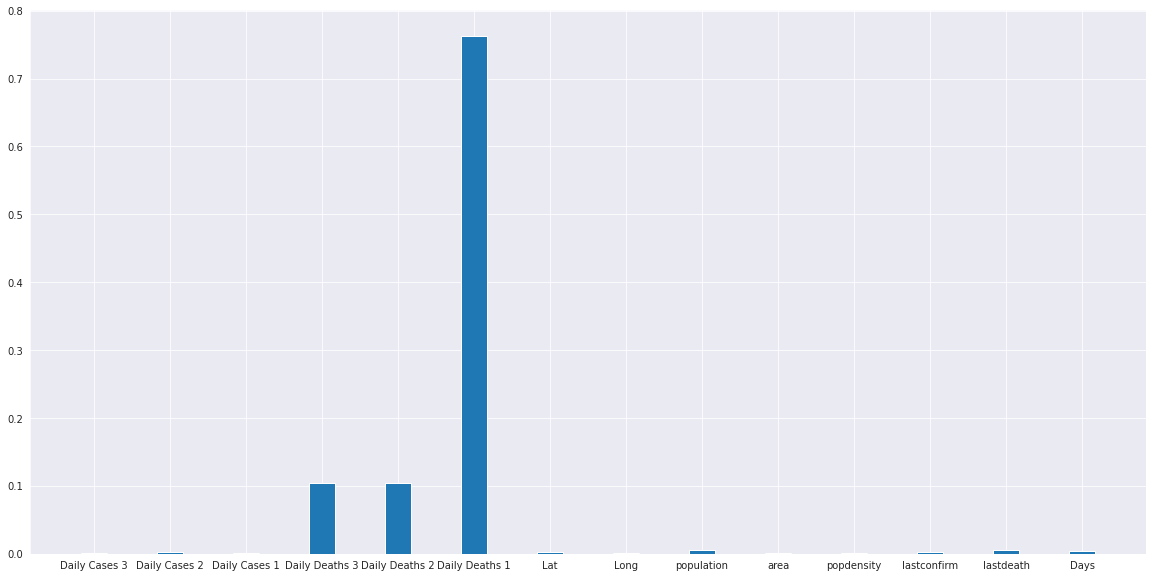

In [11]:
feature_name = ['Daily Cases 3', 'Daily Cases 2', 'Daily Cases 1', 'Daily Deaths 3','Daily Deaths 2', 'Daily Deaths 1', 'Lat', 'Long', 'population', 'area','popdensity', 'lastconfirm', 'lastdeath', 'Days']
plt.figure(figsize=(20,10))
plt.bar(feature_name, model2.feature_importances_,width = 0.35)
plt.savefig("model2_feature.png")
plt.show()

In [12]:
#for tree_index in range(num_trees):
dot = xgb.to_graphviz(model1)
dot.render("model1")

'model1.pdf'

In [13]:
dot = xgb.to_graphviz(model2)
dot.render("model2")

'model2.pdf'